# Flood Probability Prediction

## Objective
The objective of this task is to predict the FloodProbability for each row in the test dataset. Using the provided features, our goal is to build a model that can accurately estimate the probability of flooding.

## Dataset
The dataset used is derived from the Flood Prediction Factors dataset. The features are similar to the original dataset but not identical. Comparing with the original dataset can help understand the differences and improvements made.

## Libraries and Packages
We will use several libraries for data manipulation, visualization, and model building. The key libraries include:
- `numpy` and `pandas` for data manipulation
- `matplotlib` and `seaborn` for data visualization
- `ridge`, `xgboost`, and `lightgbm` for model building
- `sklearn` for various machine learning utilities
- `optuna` for hyperparameter tuning

In [1]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from scipy.stats import skew, kurtosis
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING) #silence optuna logs

## Data Loading and Exploration
In this section, we will load the dataset and perform an initial exploration to understand its structure and contents. This involves checking for missing values, understanding the distribution of features, and visualizing relationships between features and the target variable.

In [2]:
original_train = pd.read_csv('/kaggle/input/flood-prediction-factors/flood.csv') #original_train does not have id column. index_col for train and test
train_comp = pd.read_csv('/kaggle/input/playground-series-s4e5/train.csv',index_col = 'id') #train_comp: train dataset from the competition
test = pd.read_csv('/kaggle/input/playground-series-s4e5/test.csv',index_col = 'id')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s4e5/sample_submission.csv')

### Data Overview
- The dataset consists of various features that might influence the probability of flooding.
- The target variable we are predicting is `FloodProbability`.

In [3]:
print(train_comp.shape)
print(original_train.shape)
print(test.shape)

(1117957, 21)
(50000, 21)
(745305, 20)


In [4]:
train_comp.describe().T

,count,mean,std,min,25%,50%,75%,max
MonsoonIntensity,1117957.0,4.921450,2.056387,0.000,3.00,5.000,6.00,16.000
TopographyDrainage,1117957.0,4.926671,2.093879,0.000,3.00,5.000,6.00,18.000
RiverManagement,1117957.0,4.955322,2.072186,0.000,4.00,5.000,6.00,16.000
Deforestation,1117957.0,4.942240,2.051689,0.000,4.00,5.000,6.00,17.000
Urbanization,1117957.0,4.942517,2.083391,0.000,3.00,5.000,6.00,17.000
ClimateChange,1117957.0,4.934093,2.057742,0.000,3.00,5.000,6.00,17.000
DamsQuality,1117957.0,4.955878,2.083063,0.000,4.00,5.000,6.00,16.000
Siltation,1117957.0,4.927791,2.065992,0.000,3.00,5.000,6.00,16.000
AgriculturalPractices,1117957.0,4.942619,2.068545,0.000,3.00,5.000,6.00,16.000
Encroachments,1117957.0,4.949230,2.083324,0.000,4.00,5.000,6.00,18.000


In [5]:
print(train_comp.info())
print(original_train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1117957 entries, 0 to 1117956
Data columns (total 21 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   MonsoonIntensity                 1117957 non-null  int64  
 1   TopographyDrainage               1117957 non-null  int64  
 2   RiverManagement                  1117957 non-null  int64  
 3   Deforestation                    1117957 non-null  int64  
 4   Urbanization                     1117957 non-null  int64  
 5   ClimateChange                    1117957 non-null  int64  
 6   DamsQuality                      1117957 non-null  int64  
 7   Siltation                        1117957 non-null  int64  
 8   AgriculturalPractices            1117957 non-null  int64  
 9   Encroachments                    1117957 non-null  int64  
 10  IneffectiveDisasterPreparedness  1117957 non-null  int64  
 11  DrainageSystems                  1117957 non-null  int6

# Feature distribution
We will use visualizations to understand the distribution of features and their relationships with the target variable. Visualizing data helps in identifying patterns, trends, and potential outliers.

The features of test and train data have right-skewed distributions. Both dataset are the same on the histogram subplots. 

(the `train_comp` dataset is blue, and the `test` dataset is orange overlay on top of each other). 


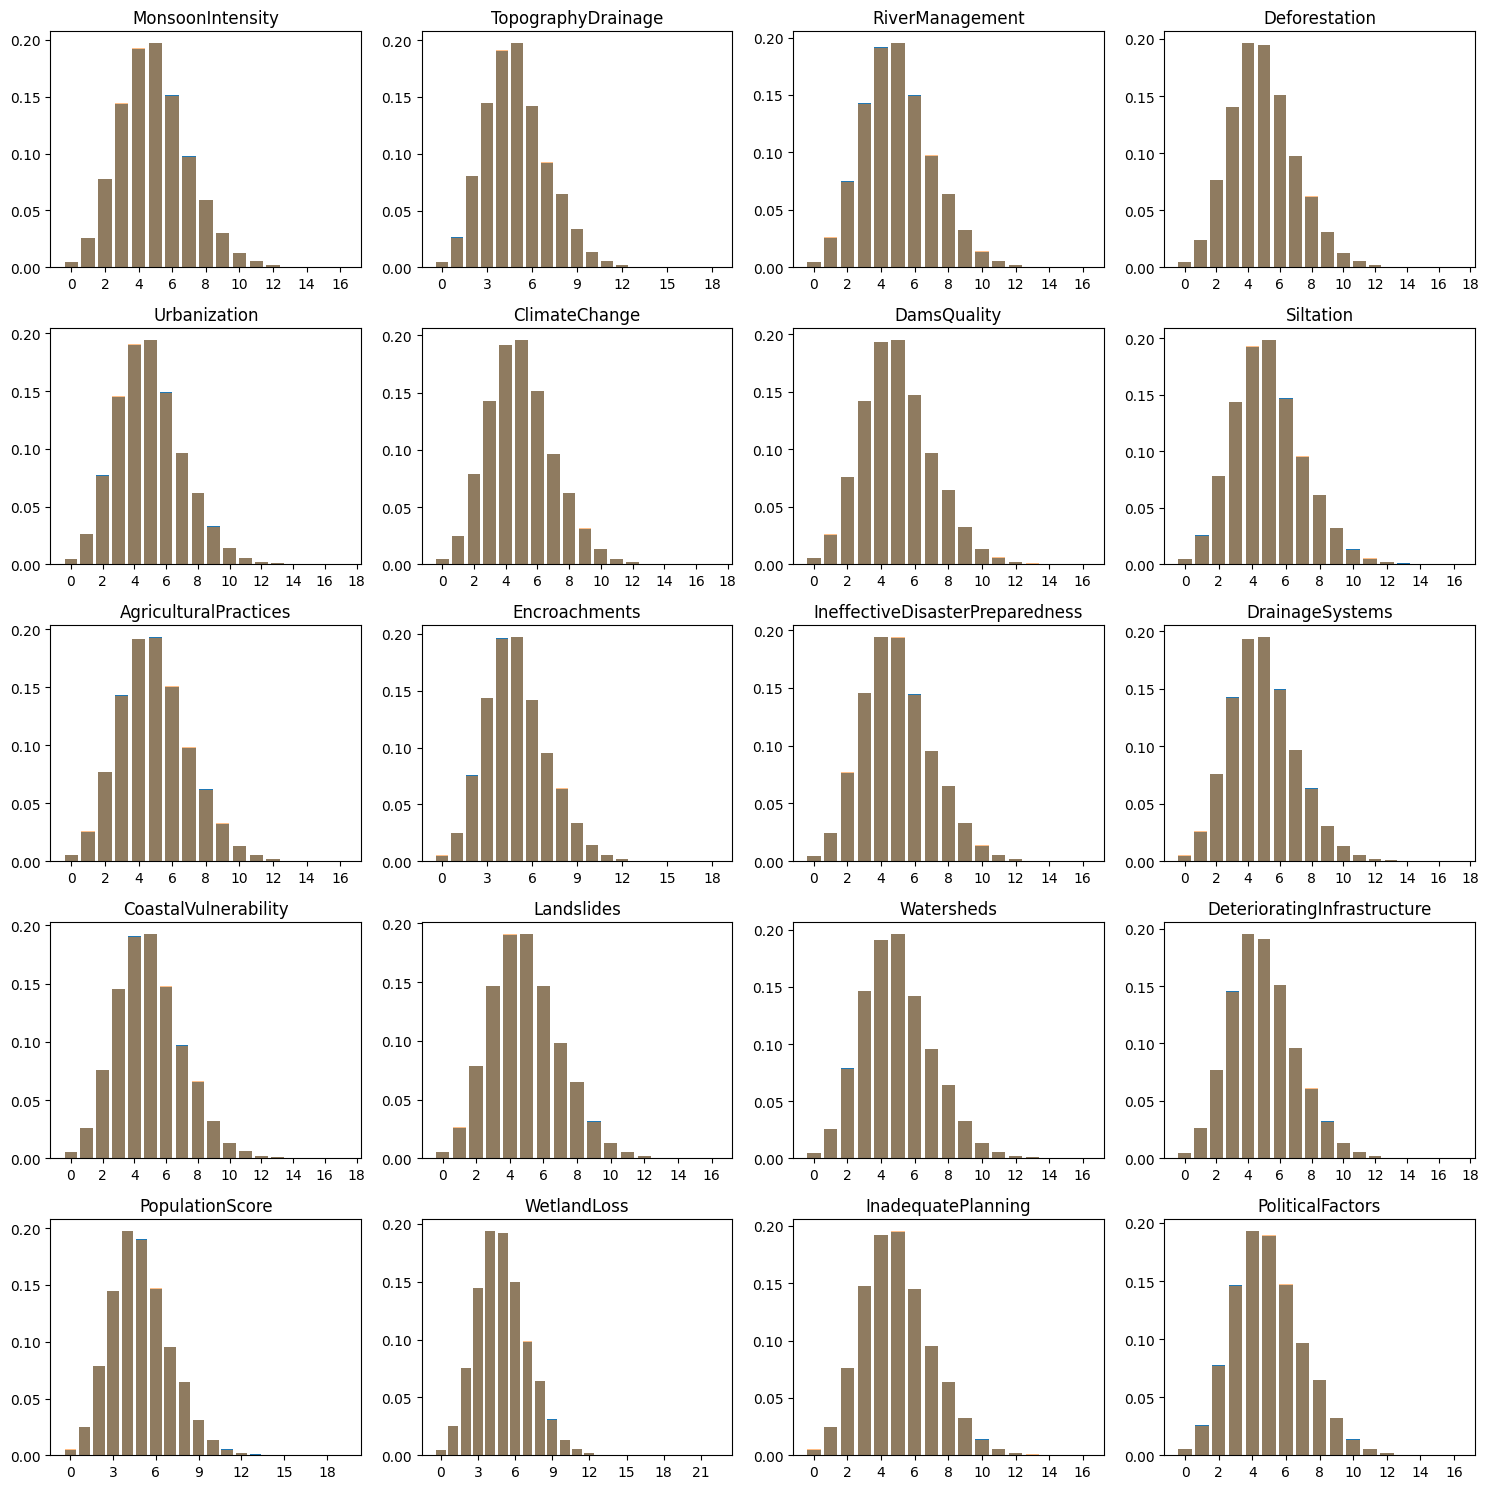

In [6]:
features = list(test.columns) #make a list of all the features nescessary for the graph

_, axs = plt.subplots(5, 4, figsize=(15,15))
for col, ax in zip(features, axs.ravel()):
    vc_train = train_comp[col].value_counts() / len(train_comp)
    ax.bar(vc_train.index, vc_train)
    vc_test = test[col].value_counts() / len(test)
    ax.bar(vc_test.index,vc_test, alpha = 0.5)
    ax.set_title(col)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True)) #force all the label to be integer
plt.tight_layout()
plt.show()

# Target Distribution

The target variable, FloodProbability, ranges from 0.285 to 0.725 with 1,117,957 observations. The mean and median values are approximately 0.5, indicating that the distribution is fairly symmetric. The standard deviation of 0.051 suggests that the flood probabilities are closely clustered around the mean. This relatively narrow range and low variability indicate a concentrated distribution of flood probabilities, with most values centered around the middle.

In [7]:
train_comp['FloodProbability'].describe()

count    1.117957e+06
mean     5.044803e-01
std      5.102610e-02
min      2.850000e-01
25%      4.700000e-01
50%      5.050000e-01
75%      5.400000e-01
max      7.250000e-01
Name: FloodProbability, dtype: float64

The KDE plot shows that the distribution of FloodProbability is unimodal and symmetric, resembling a normal distribution with a peak around 0.5. This symmetry suggests there is no significant skewness in the data. The plot confirms that most flood probabilities are concentrated around the mean, with a smooth and gradual tapering off towards the minimum and maximum values. This shape indicates a balanced spread of probabilities around the central value, reinforcing the observations from the descriptive statistics.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


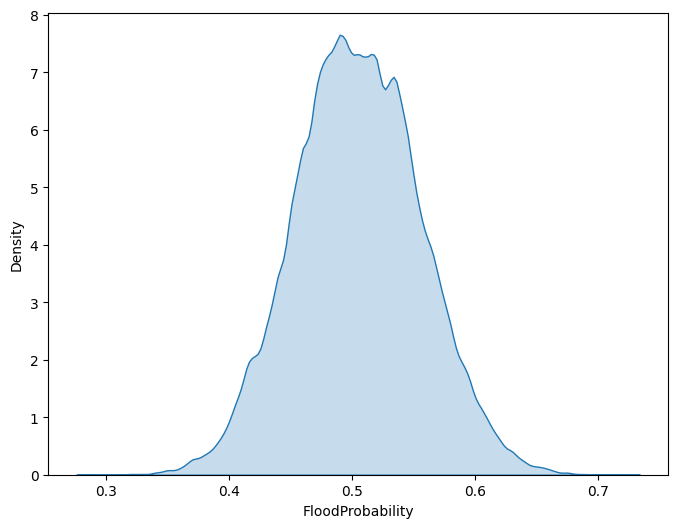

In [8]:
plt.figure(figsize=(8, 6))
sns.kdeplot(train_comp['FloodProbability'], fill = True)
plt.xlabel('FloodProbability')
plt.ylabel('Density')
plt.show()

# Incorporating the Original Dataset

### Objective
The purpose of this section is to incorporate the original dataset into our training dataset to potentially enhance the model's performance.

### Background
The dataset for this competition, including both train and test sets, was generated from a deep learning model trained on the Flood Prediction Factors dataset. While the feature distributions in our current dataset are similar to the original, they are not identical. Incorporating the original dataset allows for a comparison of differences and an assessment of whether its inclusion in training can enhance model performance.

### Dataset Overview
The original dataset can be accessed via the following link: [Flood Prediction Factors on Kaggle](https://www.kaggle.com/datasets/brijlaldhankour/flood-prediction-factors).

It contains various factors that are known to affect flood occurrences, such as rainfall, river discharge, soil moisture, and other environmental indicators.

### Potential Benefits
- **Enhanced Features**: Additional features may improve model performance.
- **Increased Data Volume**: More training examples can enhance accuracy and generalization.
- **Robust Insights**: Leveraging diverse data sources can provide deeper insights.


In [9]:
train = pd.concat([train_comp, original_train])
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1167957 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   MonsoonIntensity                 1167957 non-null  int64  
 1   TopographyDrainage               1167957 non-null  int64  
 2   RiverManagement                  1167957 non-null  int64  
 3   Deforestation                    1167957 non-null  int64  
 4   Urbanization                     1167957 non-null  int64  
 5   ClimateChange                    1167957 non-null  int64  
 6   DamsQuality                      1167957 non-null  int64  
 7   Siltation                        1167957 non-null  int64  
 8   AgriculturalPractices            1167957 non-null  int64  
 9   Encroachments                    1167957 non-null  int64  
 10  IneffectiveDisasterPreparedness  1167957 non-null  int64  
 11  DrainageSystems                  1167957 non-null  int64 

## Correlation Analysis

The correlation matrix provides insights into the relationships between the features and the target variable, `FloodProbability`.

1. **Feature Correlation**: The matrix reveals that there is no significant correlation among the features themselves. Each feature pair shows a correlation value of zero, indicating statistical independence.

2. **Target Correlation**: All features are correlated with the target variable, `FloodProbability`, with a consistent correlation value of 0.2. This uniform correlation suggests that each feature has an equal and moderate influence on the flood probability, which is an interesting characteristic of this dataset.

In summary, the correlation matrix indicates that while individual features are not correlated with each other, they each contribute equally to predicting the target variable, `FloodProbability`. This independence among features, coupled with their uniform influence on the target, can be advantageous for certain machine learning algorithms that perform well with uncorrelated input data and benefit from multiple moderate predictors.

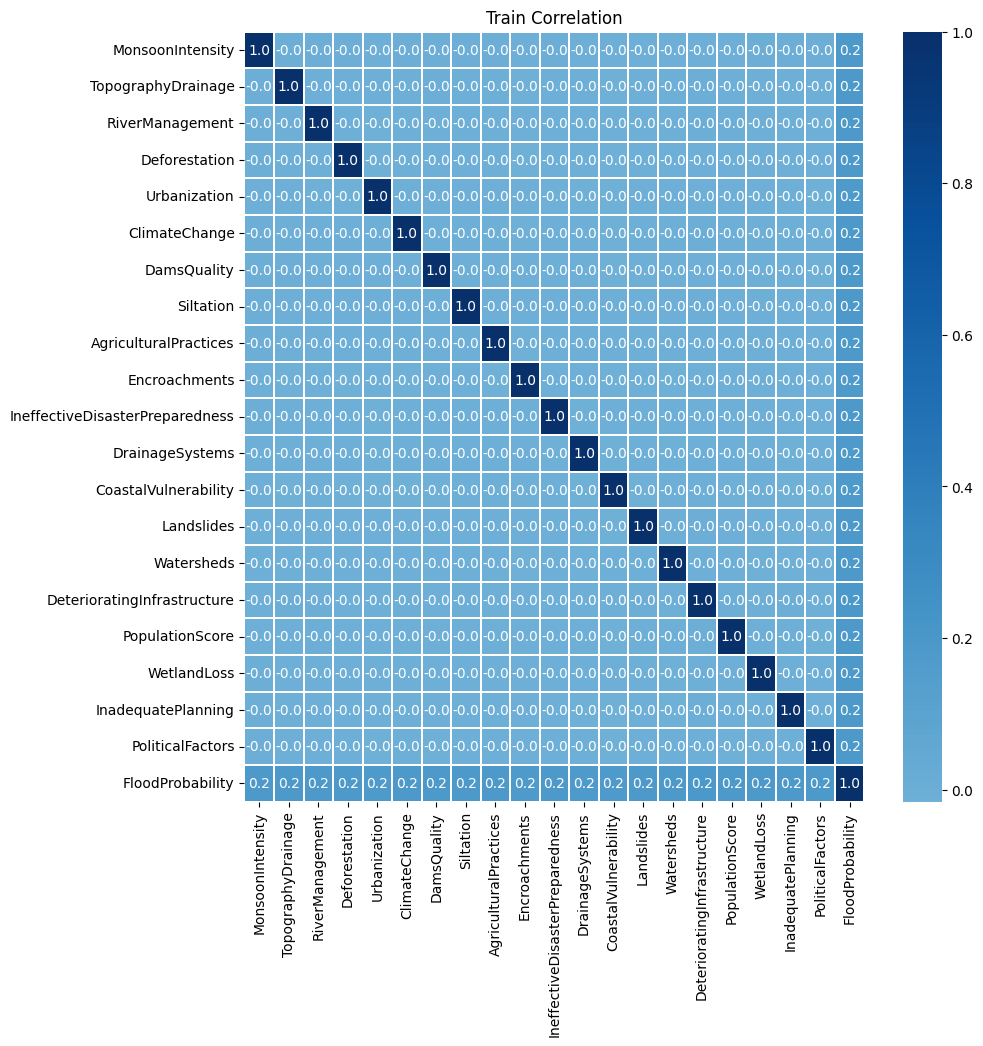

In [10]:
plt.figure(figsize=(10, 10))
sns.heatmap(train[list(train.columns)].corr(), center=0, cmap='Blues', annot=True, fmt='.1f', linewidth=.2)
plt.title('Train Correlation')
plt.show()

# Feature Engineering

### Objective
The objective of this feature engineering process is to transform and enhance the dataset to improve the performance of our predictive model. This involves creating new features and preparing the data for model training.

### Steps
1. **Target Variable Separation**
   - We first separate the target variable, `FloodProbability`, from the features.

In [11]:
target = 'FloodProbability'
X = train.copy()
y = X.pop(target)

X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

### Sorting and Summing Features

The features are sorted and a new feature representing the sum of the sorted features is added. Sorting along the feature axis is a form of feature engineering that helps capture the cumulative effect of all features.

This approach stems from the hypothesis that in the "original" dataset, the feature names are arbitrary, and the features themselves are essentially equivalent. By sorting the features, we create a symmetric function that ignores the original ordering, which can confuse some machine learning models.

Beyond just summing the sorted features, using other statistics such as variance, max, and min can also be beneficial. Sorting the features is a "lossless" technique that simplifies the feature space, helping models better understand the underlying data patterns.

More detail about sorting and summing features here: [Sorting along the feature axis as "feature engineering"](https://www.kaggle.com/competitions/playground-series-s4e5/discussion/499579) 

In [12]:
X_sorted = np.sort(X.values, axis=1)
X_new = np.c_[X_sorted, X_sorted.sum(axis=1)]

In [13]:
X_new_df = pd.DataFrame(X_new, columns=[f'feature_{i}' for i in range(X_new.shape[1] - 1)] + ['fsum'])
initial_features = X_new_df.columns[:-1]

### Adding Statistical Features

Additional statistical features are computed to capture more information about the distribution of the original features:
* Standard Deviation `fstd`: Measures the dispersion of the features.
* Special Indicator `special1`: Checks if the sum feature is within a specified range.
* Skewness `fskew`: Measures the asymmetry of the feature distribution.
* Kurtosis `fkurtosis`: Measures the tailedness of the feature distribution.

In [14]:
X_new_df['fstd'] = X_new_df[initial_features].std(axis=1)
X_new_df['special1'] = X_new_df['fsum'].isin(np.arange(72, 76))
X_new_df['fskew'] = X_new_df[initial_features].apply(lambda row: skew(row), axis=1)
X_new_df['fkurtosis'] = X_new_df[initial_features].apply(lambda row: kurtosis(row), axis=1)

### Splitting the Dataset

The enhanced dataset is split into training and validation sets to prepare for model training and evaluation.

In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(X_new_df, y, test_size=0.2, random_state=0)

# Optuna

Optuna is an automated hyperparameter optimization framework designed to efficiently search for the best hyperparameters to enhance model performance.

### Hyperparameter Tuning Process
1. **Define Objective Function**:
   - The objective function defines the hyperparameter search space for different models, including LightGBM, XGBoost, and Ridge Regression.
   - `lgm_params`, `xgb_params`, and `ridge_alpha` specify the ranges and distributions of hyperparameters to be optimized.

2. **Base Models**:
   - A combination of Ridge Regression, XGBoost, and LightGBM models are used as base models in a stacking regressor framework.
   - This ensemble approach leverages the strengths of each model type.

3. **Stacking Regressor**:
   - The stacking regressor combines predictions from the base models to produce a final prediction.
   - The Ridge Regression model is used as the final estimator in the stacking process.

4. **Model Training and Evaluation**:
   - The stacking model is trained on the training dataset.
   - Predictions are made on the validation dataset, and the R2 score is used to evaluate model performance.


In [16]:
def objective(trial):
    #base models
    lgbm_params = {
        'n_estimators': trial.suggest_int('lgbm_n_estimators', 50, 300),
        'num_leaves': trial.suggest_int('lgbm_num_leaves', 20, 150),
        'learning_rate': trial.suggest_float('lgbm_learning_rate', 1e-4, 1e-1),
        'feature_fraction': trial.suggest_float('lgbm_feature_fraction', 0.5, 1.0)
    }
    
    xgb_params = {
        'n_estimators': trial.suggest_int('xgb_n_estimators', 50, 300),
        'max_depth': trial.suggest_int('xgb_max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('xgb_learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('xgb_subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('xgb_colsample_bytree', 0.5, 1.0),
    }
    
    ridge_alpha = trial.suggest_float('ridge_alpha', 1e-2, 10.0)

    
    base_models = [
        ('ridge', Ridge(alpha=ridge_alpha)),
        ('xgb', XGBRegressor(**xgb_params)),
        ('lgbm', LGBMRegressor(**lgbm_params))
    ]
    #stacking model
    stacking_model = StackingRegressor(
        estimators=base_models,
        final_estimator=Ridge(alpha=ridge_alpha) 
    )
    
    stacking_model.fit(X_train, y_train)
    
    y_pred = stacking_model.predict(X_valid)
    return r2_score(y_valid, y_pred)

In [17]:
#optimize hyperparameters over multiple trials and display the best ones
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best hyperparameters: ", study.best_params)

/tmp/ipykernel_18/31497388.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('xgb_learning_rate', 0.01, 0.3),


[LightGBM] [Warning] feature_fraction is set=0.8157149010327033, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8157149010327033
[LightGBM] [Warning] feature_fraction is set=0.8157149010327033, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8157149010327033
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.312648 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 934365, number of used features: 25
[LightGBM] [Info] Start training from score 0.504262
[LightGBM] [Warning] feature_fraction is set=0.8157149010327033, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8157149010327033
[LightGBM] [Warning] feature_fraction is set=0.8157149010327033, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8157149010327033
[LightGBM] [Info] Auto-choosing col-wise 

/tmp/ipykernel_18/31497388.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('xgb_learning_rate', 0.01, 0.3),


[LightGBM] [Warning] feature_fraction is set=0.6775859359900536, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6775859359900536
[LightGBM] [Warning] feature_fraction is set=0.6775859359900536, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6775859359900536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.596183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 934365, number of used features: 25
[LightGBM] [Info] Start training from score 0.504262
[LightGBM] [Warning] feature_fraction is set=0.6775859359900536, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6775859359900536
[LightGBM] [Warning] feature_fraction is set=0.6775859359900536, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6775859359900536
[LightGBM] [Info] Auto-choosing col-wise 

/tmp/ipykernel_18/31497388.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('xgb_learning_rate', 0.01, 0.3),


[LightGBM] [Warning] feature_fraction is set=0.7912349223770583, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7912349223770583
[LightGBM] [Warning] feature_fraction is set=0.7912349223770583, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7912349223770583
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.613627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 934365, number of used features: 25
[LightGBM] [Info] Start training from score 0.504262
[LightGBM] [Warning] feature_fraction is set=0.7912349223770583, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7912349223770583
[LightGBM] [Warning] feature_fraction is set=0.7912349223770583, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7912349223770583
[LightGBM] [Info] Auto-choosing col-wise 

/tmp/ipykernel_18/31497388.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('xgb_learning_rate', 0.01, 0.3),


[LightGBM] [Warning] feature_fraction is set=0.9629377059317357, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9629377059317357
[LightGBM] [Warning] feature_fraction is set=0.9629377059317357, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9629377059317357
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.627363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 934365, number of used features: 25
[LightGBM] [Info] Start training from score 0.504262
[LightGBM] [Warning] feature_fraction is set=0.9629377059317357, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9629377059317357
[LightGBM] [Warning] feature_fraction is set=0.9629377059317357, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9629377059317357
[LightGBM] [Info] Auto-choosing col-wise 

/tmp/ipykernel_18/31497388.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('xgb_learning_rate', 0.01, 0.3),


[LightGBM] [Warning] feature_fraction is set=0.8545505995301164, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8545505995301164
[LightGBM] [Warning] feature_fraction is set=0.8545505995301164, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8545505995301164
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.612668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 934365, number of used features: 25
[LightGBM] [Info] Start training from score 0.504262
[LightGBM] [Warning] feature_fraction is set=0.8545505995301164, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8545505995301164
[LightGBM] [Warning] feature_fraction is set=0.8545505995301164, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8545505995301164
[LightGBM] [Info] Auto-choosing col-wise 

/tmp/ipykernel_18/31497388.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('xgb_learning_rate', 0.01, 0.3),


[LightGBM] [Warning] feature_fraction is set=0.8048354949636607, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8048354949636607
[LightGBM] [Warning] feature_fraction is set=0.8048354949636607, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8048354949636607
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.612201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 934365, number of used features: 25
[LightGBM] [Info] Start training from score 0.504262
[LightGBM] [Warning] feature_fraction is set=0.8048354949636607, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8048354949636607
[LightGBM] [Warning] feature_fraction is set=0.8048354949636607, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8048354949636607
[LightGBM] [Info] Auto-choosing col-wise 

/tmp/ipykernel_18/31497388.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('xgb_learning_rate', 0.01, 0.3),


[LightGBM] [Warning] feature_fraction is set=0.5043106143867129, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5043106143867129
[LightGBM] [Warning] feature_fraction is set=0.5043106143867129, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5043106143867129
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.517401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 934365, number of used features: 25
[LightGBM] [Info] Start training from score 0.504262
[LightGBM] [Warning] feature_fraction is set=0.5043106143867129, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5043106143867129
[LightGBM] [Warning] feature_fraction is set=0.5043106143867129, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5043106143867129
[LightGBM] [Info] Auto-choosing col-wise 

/tmp/ipykernel_18/31497388.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('xgb_learning_rate', 0.01, 0.3),


[LightGBM] [Warning] feature_fraction is set=0.7759290478835744, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7759290478835744
[LightGBM] [Warning] feature_fraction is set=0.7759290478835744, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7759290478835744
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.600079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 934365, number of used features: 25
[LightGBM] [Info] Start training from score 0.504262
[LightGBM] [Warning] feature_fraction is set=0.7759290478835744, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7759290478835744
[LightGBM] [Warning] feature_fraction is set=0.7759290478835744, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7759290478835744
[LightGBM] [Info] Auto-choosing col-wise 

/tmp/ipykernel_18/31497388.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('xgb_learning_rate', 0.01, 0.3),


[LightGBM] [Warning] feature_fraction is set=0.8145588767449667, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8145588767449667
[LightGBM] [Warning] feature_fraction is set=0.8145588767449667, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8145588767449667
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.610895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 934365, number of used features: 25
[LightGBM] [Info] Start training from score 0.504262
[LightGBM] [Warning] feature_fraction is set=0.8145588767449667, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8145588767449667
[LightGBM] [Warning] feature_fraction is set=0.8145588767449667, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8145588767449667
[LightGBM] [Info] Auto-choosing col-wise 

/tmp/ipykernel_18/31497388.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('xgb_learning_rate', 0.01, 0.3),


[LightGBM] [Warning] feature_fraction is set=0.7134484658970461, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7134484658970461
[LightGBM] [Warning] feature_fraction is set=0.7134484658970461, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7134484658970461
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.603072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 934365, number of used features: 25
[LightGBM] [Info] Start training from score 0.504262
[LightGBM] [Warning] feature_fraction is set=0.7134484658970461, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7134484658970461
[LightGBM] [Warning] feature_fraction is set=0.7134484658970461, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7134484658970461
[LightGBM] [Info] Auto-choosing col-wise 

/tmp/ipykernel_18/31497388.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('xgb_learning_rate', 0.01, 0.3),


[LightGBM] [Warning] feature_fraction is set=0.9986547339396801, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9986547339396801
[LightGBM] [Warning] feature_fraction is set=0.9986547339396801, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9986547339396801
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.626518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 934365, number of used features: 25
[LightGBM] [Info] Start training from score 0.504262
[LightGBM] [Warning] feature_fraction is set=0.9986547339396801, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9986547339396801
[LightGBM] [Warning] feature_fraction is set=0.9986547339396801, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9986547339396801
[LightGBM] [Info] Auto-choosing col-wise 

/tmp/ipykernel_18/31497388.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('xgb_learning_rate', 0.01, 0.3),


[LightGBM] [Warning] feature_fraction is set=0.9715247941212908, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9715247941212908
[LightGBM] [Warning] feature_fraction is set=0.9715247941212908, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9715247941212908
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.628656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 934365, number of used features: 25
[LightGBM] [Info] Start training from score 0.504262
[LightGBM] [Warning] feature_fraction is set=0.9715247941212908, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9715247941212908
[LightGBM] [Warning] feature_fraction is set=0.9715247941212908, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9715247941212908
[LightGBM] [Info] Auto-choosing col-wise 

/tmp/ipykernel_18/31497388.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('xgb_learning_rate', 0.01, 0.3),


[LightGBM] [Warning] feature_fraction is set=0.9993191409728176, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9993191409728176
[LightGBM] [Warning] feature_fraction is set=0.9993191409728176, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9993191409728176
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.632642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 934365, number of used features: 25
[LightGBM] [Info] Start training from score 0.504262
[LightGBM] [Warning] feature_fraction is set=0.9993191409728176, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9993191409728176
[LightGBM] [Warning] feature_fraction is set=0.9993191409728176, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9993191409728176
[LightGBM] [Info] Auto-choosing col-wise 

/tmp/ipykernel_18/31497388.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('xgb_learning_rate', 0.01, 0.3),


[LightGBM] [Warning] feature_fraction is set=0.9063531730349489, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9063531730349489
[LightGBM] [Warning] feature_fraction is set=0.9063531730349489, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9063531730349489
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.626107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 934365, number of used features: 25
[LightGBM] [Info] Start training from score 0.504262
[LightGBM] [Warning] feature_fraction is set=0.9063531730349489, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9063531730349489
[LightGBM] [Warning] feature_fraction is set=0.9063531730349489, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9063531730349489
[LightGBM] [Info] Auto-choosing col-wise 

/tmp/ipykernel_18/31497388.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('xgb_learning_rate', 0.01, 0.3),


[LightGBM] [Warning] feature_fraction is set=0.893479589358746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.893479589358746
[LightGBM] [Warning] feature_fraction is set=0.893479589358746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.893479589358746
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.615410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 934365, number of used features: 25
[LightGBM] [Info] Start training from score 0.504262
[LightGBM] [Warning] feature_fraction is set=0.893479589358746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.893479589358746
[LightGBM] [Warning] feature_fraction is set=0.893479589358746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.893479589358746
[LightGBM] [Info] Auto-choosing col-wise multi-th

/tmp/ipykernel_18/31497388.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('xgb_learning_rate', 0.01, 0.3),


[LightGBM] [Warning] feature_fraction is set=0.9146091985320718, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9146091985320718
[LightGBM] [Warning] feature_fraction is set=0.9146091985320718, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9146091985320718
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.623960 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 934365, number of used features: 25
[LightGBM] [Info] Start training from score 0.504262
[LightGBM] [Warning] feature_fraction is set=0.9146091985320718, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9146091985320718
[LightGBM] [Warning] feature_fraction is set=0.9146091985320718, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9146091985320718
[LightGBM] [Info] Auto-choosing col-wise 

/tmp/ipykernel_18/31497388.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('xgb_learning_rate', 0.01, 0.3),


[LightGBM] [Warning] feature_fraction is set=0.9205225407019484, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9205225407019484
[LightGBM] [Warning] feature_fraction is set=0.9205225407019484, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9205225407019484
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.619707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 934365, number of used features: 25
[LightGBM] [Info] Start training from score 0.504262
[LightGBM] [Warning] feature_fraction is set=0.9205225407019484, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9205225407019484
[LightGBM] [Warning] feature_fraction is set=0.9205225407019484, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9205225407019484
[LightGBM] [Info] Auto-choosing col-wise 

/tmp/ipykernel_18/31497388.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('xgb_learning_rate', 0.01, 0.3),


[LightGBM] [Warning] feature_fraction is set=0.6613689915558827, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6613689915558827
[LightGBM] [Warning] feature_fraction is set=0.6613689915558827, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6613689915558827
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.600920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 934365, number of used features: 25
[LightGBM] [Info] Start training from score 0.504262
[LightGBM] [Warning] feature_fraction is set=0.6613689915558827, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6613689915558827
[LightGBM] [Warning] feature_fraction is set=0.6613689915558827, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6613689915558827
[LightGBM] [Info] Auto-choosing col-wise 

/tmp/ipykernel_18/31497388.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('xgb_learning_rate', 0.01, 0.3),


[LightGBM] [Warning] feature_fraction is set=0.5701594201989326, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5701594201989326
[LightGBM] [Warning] feature_fraction is set=0.5701594201989326, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5701594201989326
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.531515 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 934365, number of used features: 25
[LightGBM] [Info] Start training from score 0.504262
[LightGBM] [Warning] feature_fraction is set=0.5701594201989326, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5701594201989326
[LightGBM] [Warning] feature_fraction is set=0.5701594201989326, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5701594201989326
[LightGBM] [Info] Auto-choosing col-wise 

/tmp/ipykernel_18/31497388.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('xgb_learning_rate', 0.01, 0.3),


[LightGBM] [Warning] feature_fraction is set=0.8718193599162958, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8718193599162958
[LightGBM] [Warning] feature_fraction is set=0.8718193599162958, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8718193599162958
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.668911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 934365, number of used features: 25
[LightGBM] [Info] Start training from score 0.504262
[LightGBM] [Warning] feature_fraction is set=0.8718193599162958, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8718193599162958
[LightGBM] [Warning] feature_fraction is set=0.8718193599162958, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8718193599162958
[LightGBM] [Info] Auto-choosing col-wise 

/tmp/ipykernel_18/31497388.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('xgb_learning_rate', 0.01, 0.3),


[LightGBM] [Warning] feature_fraction is set=0.9466613286571872, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9466613286571872
[LightGBM] [Warning] feature_fraction is set=0.9466613286571872, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9466613286571872
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.626109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 934365, number of used features: 25
[LightGBM] [Info] Start training from score 0.504262
[LightGBM] [Warning] feature_fraction is set=0.9466613286571872, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9466613286571872
[LightGBM] [Warning] feature_fraction is set=0.9466613286571872, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9466613286571872
[LightGBM] [Info] Auto-choosing col-wise 

/tmp/ipykernel_18/31497388.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('xgb_learning_rate', 0.01, 0.3),


[LightGBM] [Warning] feature_fraction is set=0.9877557649093632, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9877557649093632
[LightGBM] [Warning] feature_fraction is set=0.9877557649093632, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9877557649093632
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.627049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 934365, number of used features: 25
[LightGBM] [Info] Start training from score 0.504262
[LightGBM] [Warning] feature_fraction is set=0.9877557649093632, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9877557649093632
[LightGBM] [Warning] feature_fraction is set=0.9877557649093632, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9877557649093632
[LightGBM] [Info] Auto-choosing col-wise 

/tmp/ipykernel_18/31497388.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('xgb_learning_rate', 0.01, 0.3),


[LightGBM] [Warning] feature_fraction is set=0.9949290109538822, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9949290109538822
[LightGBM] [Warning] feature_fraction is set=0.9949290109538822, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9949290109538822
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.629123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 934365, number of used features: 25
[LightGBM] [Info] Start training from score 0.504262
[LightGBM] [Warning] feature_fraction is set=0.9949290109538822, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9949290109538822
[LightGBM] [Warning] feature_fraction is set=0.9949290109538822, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9949290109538822
[LightGBM] [Info] Auto-choosing col-wise 

/tmp/ipykernel_18/31497388.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('xgb_learning_rate', 0.01, 0.3),


[LightGBM] [Warning] feature_fraction is set=0.9928958801561073, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9928958801561073
[LightGBM] [Warning] feature_fraction is set=0.9928958801561073, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9928958801561073
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.644360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 934365, number of used features: 25
[LightGBM] [Info] Start training from score 0.504262
[LightGBM] [Warning] feature_fraction is set=0.9928958801561073, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9928958801561073
[LightGBM] [Warning] feature_fraction is set=0.9928958801561073, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9928958801561073
[LightGBM] [Info] Auto-choosing col-wise 

/tmp/ipykernel_18/31497388.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('xgb_learning_rate', 0.01, 0.3),


[LightGBM] [Warning] feature_fraction is set=0.9445528584604466, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9445528584604466
[LightGBM] [Warning] feature_fraction is set=0.9445528584604466, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9445528584604466
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.623535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 934365, number of used features: 25
[LightGBM] [Info] Start training from score 0.504262
[LightGBM] [Warning] feature_fraction is set=0.9445528584604466, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9445528584604466
[LightGBM] [Warning] feature_fraction is set=0.9445528584604466, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9445528584604466
[LightGBM] [Info] Auto-choosing col-wise 

/tmp/ipykernel_18/31497388.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('xgb_learning_rate', 0.01, 0.3),


[LightGBM] [Warning] feature_fraction is set=0.8603427238053017, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8603427238053017
[LightGBM] [Warning] feature_fraction is set=0.8603427238053017, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8603427238053017
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.618086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 934365, number of used features: 25
[LightGBM] [Info] Start training from score 0.504262
[LightGBM] [Warning] feature_fraction is set=0.8603427238053017, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8603427238053017
[LightGBM] [Warning] feature_fraction is set=0.8603427238053017, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8603427238053017
[LightGBM] [Info] Auto-choosing col-wise 

/tmp/ipykernel_18/31497388.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('xgb_learning_rate', 0.01, 0.3),


[LightGBM] [Warning] feature_fraction is set=0.9476753712178589, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9476753712178589
[LightGBM] [Warning] feature_fraction is set=0.9476753712178589, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9476753712178589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.627332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 934365, number of used features: 25
[LightGBM] [Info] Start training from score 0.504262
[LightGBM] [Warning] feature_fraction is set=0.9476753712178589, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9476753712178589
[LightGBM] [Warning] feature_fraction is set=0.9476753712178589, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9476753712178589
[LightGBM] [Info] Auto-choosing col-wise 

/tmp/ipykernel_18/31497388.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('xgb_learning_rate', 0.01, 0.3),


[LightGBM] [Warning] feature_fraction is set=0.9998353445088769, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9998353445088769
[LightGBM] [Warning] feature_fraction is set=0.9998353445088769, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9998353445088769
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.631342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 934365, number of used features: 25
[LightGBM] [Info] Start training from score 0.504262
[LightGBM] [Warning] feature_fraction is set=0.9998353445088769, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9998353445088769
[LightGBM] [Warning] feature_fraction is set=0.9998353445088769, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9998353445088769
[LightGBM] [Info] Auto-choosing col-wise 

/tmp/ipykernel_18/31497388.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('xgb_learning_rate', 0.01, 0.3),


[LightGBM] [Warning] feature_fraction is set=0.8424589952960073, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8424589952960073
[LightGBM] [Warning] feature_fraction is set=0.8424589952960073, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8424589952960073
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.611377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 934365, number of used features: 25
[LightGBM] [Info] Start training from score 0.504262
[LightGBM] [Warning] feature_fraction is set=0.8424589952960073, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8424589952960073
[LightGBM] [Warning] feature_fraction is set=0.8424589952960073, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8424589952960073
[LightGBM] [Info] Auto-choosing col-wise 

/tmp/ipykernel_18/31497388.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('xgb_learning_rate', 0.01, 0.3),


[LightGBM] [Warning] feature_fraction is set=0.9374306240537171, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9374306240537171
[LightGBM] [Warning] feature_fraction is set=0.9374306240537171, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9374306240537171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.627238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 934365, number of used features: 25
[LightGBM] [Info] Start training from score 0.504262
[LightGBM] [Warning] feature_fraction is set=0.9374306240537171, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9374306240537171
[LightGBM] [Warning] feature_fraction is set=0.9374306240537171, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9374306240537171
[LightGBM] [Info] Auto-choosing col-wise 

/tmp/ipykernel_18/31497388.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('xgb_learning_rate', 0.01, 0.3),


[LightGBM] [Warning] feature_fraction is set=0.8867897159632377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8867897159632377
[LightGBM] [Warning] feature_fraction is set=0.8867897159632377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8867897159632377
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.613260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 934365, number of used features: 25
[LightGBM] [Info] Start training from score 0.504262
[LightGBM] [Warning] feature_fraction is set=0.8867897159632377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8867897159632377
[LightGBM] [Warning] feature_fraction is set=0.8867897159632377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8867897159632377
[LightGBM] [Info] Auto-choosing col-wise 

/tmp/ipykernel_18/31497388.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('xgb_learning_rate', 0.01, 0.3),


[LightGBM] [Warning] feature_fraction is set=0.9999070452393748, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9999070452393748
[LightGBM] [Warning] feature_fraction is set=0.9999070452393748, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9999070452393748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.623853 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 934365, number of used features: 25
[LightGBM] [Info] Start training from score 0.504262
[LightGBM] [Warning] feature_fraction is set=0.9999070452393748, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9999070452393748
[LightGBM] [Warning] feature_fraction is set=0.9999070452393748, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9999070452393748
[LightGBM] [Info] Auto-choosing col-wise 

/tmp/ipykernel_18/31497388.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('xgb_learning_rate', 0.01, 0.3),


[LightGBM] [Warning] feature_fraction is set=0.9811611595597374, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9811611595597374
[LightGBM] [Warning] feature_fraction is set=0.9811611595597374, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9811611595597374
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.632097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 934365, number of used features: 25
[LightGBM] [Info] Start training from score 0.504262
[LightGBM] [Warning] feature_fraction is set=0.9811611595597374, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9811611595597374
[LightGBM] [Warning] feature_fraction is set=0.9811611595597374, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9811611595597374
[LightGBM] [Info] Auto-choosing col-wise 

/tmp/ipykernel_18/31497388.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('xgb_learning_rate', 0.01, 0.3),


[LightGBM] [Warning] feature_fraction is set=0.9690845284354113, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9690845284354113
[LightGBM] [Warning] feature_fraction is set=0.9690845284354113, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9690845284354113
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.632012 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 934365, number of used features: 25
[LightGBM] [Info] Start training from score 0.504262
[LightGBM] [Warning] feature_fraction is set=0.9690845284354113, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9690845284354113
[LightGBM] [Warning] feature_fraction is set=0.9690845284354113, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9690845284354113
[LightGBM] [Info] Auto-choosing col-wise 

/tmp/ipykernel_18/31497388.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('xgb_learning_rate', 0.01, 0.3),


[LightGBM] [Warning] feature_fraction is set=0.9190962636771807, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9190962636771807
[LightGBM] [Warning] feature_fraction is set=0.9190962636771807, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9190962636771807
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.625796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 934365, number of used features: 25
[LightGBM] [Info] Start training from score 0.504262
[LightGBM] [Warning] feature_fraction is set=0.9190962636771807, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9190962636771807
[LightGBM] [Warning] feature_fraction is set=0.9190962636771807, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9190962636771807
[LightGBM] [Info] Auto-choosing col-wise 

/tmp/ipykernel_18/31497388.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('xgb_learning_rate', 0.01, 0.3),


[LightGBM] [Warning] feature_fraction is set=0.9655072340912638, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9655072340912638
[LightGBM] [Warning] feature_fraction is set=0.9655072340912638, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9655072340912638
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.621736 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 934365, number of used features: 25
[LightGBM] [Info] Start training from score 0.504262
[LightGBM] [Warning] feature_fraction is set=0.9655072340912638, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9655072340912638
[LightGBM] [Warning] feature_fraction is set=0.9655072340912638, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9655072340912638
[LightGBM] [Info] Auto-choosing col-wise 

/tmp/ipykernel_18/31497388.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('xgb_learning_rate', 0.01, 0.3),


[LightGBM] [Warning] feature_fraction is set=0.9535910528214013, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9535910528214013
[LightGBM] [Warning] feature_fraction is set=0.9535910528214013, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9535910528214013
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.622726 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 934365, number of used features: 25
[LightGBM] [Info] Start training from score 0.504262
[LightGBM] [Warning] feature_fraction is set=0.9535910528214013, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9535910528214013
[LightGBM] [Warning] feature_fraction is set=0.9535910528214013, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9535910528214013
[LightGBM] [Info] Auto-choosing col-wise 

/tmp/ipykernel_18/31497388.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('xgb_learning_rate', 0.01, 0.3),


[LightGBM] [Warning] feature_fraction is set=0.7399872748985933, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7399872748985933
[LightGBM] [Warning] feature_fraction is set=0.7399872748985933, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7399872748985933
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.611456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 934365, number of used features: 25
[LightGBM] [Info] Start training from score 0.504262
[LightGBM] [Warning] feature_fraction is set=0.7399872748985933, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7399872748985933
[LightGBM] [Warning] feature_fraction is set=0.7399872748985933, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7399872748985933
[LightGBM] [Info] Auto-choosing col-wise 

/tmp/ipykernel_18/31497388.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('xgb_learning_rate', 0.01, 0.3),


[LightGBM] [Warning] feature_fraction is set=0.6208360415853478, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6208360415853478
[LightGBM] [Warning] feature_fraction is set=0.6208360415853478, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6208360415853478
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.605732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 934365, number of used features: 25
[LightGBM] [Info] Start training from score 0.504262
[LightGBM] [Warning] feature_fraction is set=0.6208360415853478, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6208360415853478
[LightGBM] [Warning] feature_fraction is set=0.6208360415853478, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6208360415853478
[LightGBM] [Info] Auto-choosing col-wise 

/tmp/ipykernel_18/31497388.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('xgb_learning_rate', 0.01, 0.3),


[LightGBM] [Warning] feature_fraction is set=0.8300362444113069, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8300362444113069
[LightGBM] [Warning] feature_fraction is set=0.8300362444113069, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8300362444113069
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.612149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 934365, number of used features: 25
[LightGBM] [Info] Start training from score 0.504262
[LightGBM] [Warning] feature_fraction is set=0.8300362444113069, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8300362444113069
[LightGBM] [Warning] feature_fraction is set=0.8300362444113069, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8300362444113069
[LightGBM] [Info] Auto-choosing col-wise 

/tmp/ipykernel_18/31497388.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('xgb_learning_rate', 0.01, 0.3),


[LightGBM] [Warning] feature_fraction is set=0.9627027115777231, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9627027115777231
[LightGBM] [Warning] feature_fraction is set=0.9627027115777231, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9627027115777231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.630500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 934365, number of used features: 25
[LightGBM] [Info] Start training from score 0.504262
[LightGBM] [Warning] feature_fraction is set=0.9627027115777231, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9627027115777231
[LightGBM] [Warning] feature_fraction is set=0.9627027115777231, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9627027115777231
[LightGBM] [Info] Auto-choosing col-wise 

/tmp/ipykernel_18/31497388.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('xgb_learning_rate', 0.01, 0.3),


[LightGBM] [Warning] feature_fraction is set=0.9831473164106925, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9831473164106925
[LightGBM] [Warning] feature_fraction is set=0.9831473164106925, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9831473164106925
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.628025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 934365, number of used features: 25
[LightGBM] [Info] Start training from score 0.504262
[LightGBM] [Warning] feature_fraction is set=0.9831473164106925, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9831473164106925
[LightGBM] [Warning] feature_fraction is set=0.9831473164106925, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9831473164106925
[LightGBM] [Info] Auto-choosing col-wise 

/tmp/ipykernel_18/31497388.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('xgb_learning_rate', 0.01, 0.3),


[LightGBM] [Warning] feature_fraction is set=0.9314717801411355, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9314717801411355
[LightGBM] [Warning] feature_fraction is set=0.9314717801411355, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9314717801411355
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.625116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 934365, number of used features: 25
[LightGBM] [Info] Start training from score 0.504262
[LightGBM] [Warning] feature_fraction is set=0.9314717801411355, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9314717801411355
[LightGBM] [Warning] feature_fraction is set=0.9314717801411355, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9314717801411355
[LightGBM] [Info] Auto-choosing col-wise 

/tmp/ipykernel_18/31497388.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('xgb_learning_rate', 0.01, 0.3),


[LightGBM] [Warning] feature_fraction is set=0.968834158441829, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.968834158441829
[LightGBM] [Warning] feature_fraction is set=0.968834158441829, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.968834158441829
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.621252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 934365, number of used features: 25
[LightGBM] [Info] Start training from score 0.504262
[LightGBM] [Warning] feature_fraction is set=0.968834158441829, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.968834158441829
[LightGBM] [Warning] feature_fraction is set=0.968834158441829, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.968834158441829
[LightGBM] [Info] Auto-choosing col-wise multi-th

/tmp/ipykernel_18/31497388.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('xgb_learning_rate', 0.01, 0.3),


[LightGBM] [Warning] feature_fraction is set=0.9927181601825809, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9927181601825809
[LightGBM] [Warning] feature_fraction is set=0.9927181601825809, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9927181601825809
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.626959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 934365, number of used features: 25
[LightGBM] [Info] Start training from score 0.504262
[LightGBM] [Warning] feature_fraction is set=0.9927181601825809, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9927181601825809
[LightGBM] [Warning] feature_fraction is set=0.9927181601825809, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9927181601825809
[LightGBM] [Info] Auto-choosing col-wise 

/tmp/ipykernel_18/31497388.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('xgb_learning_rate', 0.01, 0.3),


[LightGBM] [Warning] feature_fraction is set=0.7804725959028829, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7804725959028829
[LightGBM] [Warning] feature_fraction is set=0.7804725959028829, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7804725959028829
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.616175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 934365, number of used features: 25
[LightGBM] [Info] Start training from score 0.504262
[LightGBM] [Warning] feature_fraction is set=0.7804725959028829, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7804725959028829
[LightGBM] [Warning] feature_fraction is set=0.7804725959028829, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7804725959028829
[LightGBM] [Info] Auto-choosing col-wise 

/tmp/ipykernel_18/31497388.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('xgb_learning_rate', 0.01, 0.3),


[LightGBM] [Warning] feature_fraction is set=0.8884060518928537, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8884060518928537
[LightGBM] [Warning] feature_fraction is set=0.8884060518928537, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8884060518928537
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.631051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 934365, number of used features: 25
[LightGBM] [Info] Start training from score 0.504262
[LightGBM] [Warning] feature_fraction is set=0.8884060518928537, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8884060518928537
[LightGBM] [Warning] feature_fraction is set=0.8884060518928537, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8884060518928537
[LightGBM] [Info] Auto-choosing col-wise 

/tmp/ipykernel_18/31497388.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('xgb_learning_rate', 0.01, 0.3),


[LightGBM] [Warning] feature_fraction is set=0.971849316697571, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.971849316697571
[LightGBM] [Warning] feature_fraction is set=0.971849316697571, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.971849316697571
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.641669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 934365, number of used features: 25
[LightGBM] [Info] Start training from score 0.504262
[LightGBM] [Warning] feature_fraction is set=0.971849316697571, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.971849316697571
[LightGBM] [Warning] feature_fraction is set=0.971849316697571, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.971849316697571
[LightGBM] [Info] Auto-choosing col-wise multi-th

/tmp/ipykernel_18/31497388.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('xgb_learning_rate', 0.01, 0.3),


[LightGBM] [Warning] feature_fraction is set=0.9925148556154331, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9925148556154331
[LightGBM] [Warning] feature_fraction is set=0.9925148556154331, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9925148556154331
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.618064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 934365, number of used features: 25
[LightGBM] [Info] Start training from score 0.504262
[LightGBM] [Warning] feature_fraction is set=0.9925148556154331, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9925148556154331
[LightGBM] [Warning] feature_fraction is set=0.9925148556154331, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9925148556154331
[LightGBM] [Info] Auto-choosing col-wise 

/tmp/ipykernel_18/31497388.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('xgb_learning_rate', 0.01, 0.3),


[LightGBM] [Warning] feature_fraction is set=0.9018824347963471, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9018824347963471
[LightGBM] [Warning] feature_fraction is set=0.9018824347963471, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9018824347963471
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.624583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 934365, number of used features: 25
[LightGBM] [Info] Start training from score 0.504262
[LightGBM] [Warning] feature_fraction is set=0.9018824347963471, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9018824347963471
[LightGBM] [Warning] feature_fraction is set=0.9018824347963471, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9018824347963471
[LightGBM] [Info] Auto-choosing col-wise 

## Final Model Training and Evaluation with Optimized Hyperparameters
We utilize the best hyperparameters found through Optuna optimization to train and evaluate the final stacking model.

### Best Hyperparameters
We retrieve the best hyperparameters for LightGBM, XGBoost, and Ridge Regression from the Optuna study.

In [18]:
best_params = study.best_params

lgbm_best_params = {
    'n_estimators': best_params['lgbm_n_estimators'],
    'num_leaves': best_params['lgbm_num_leaves'],
    'learning_rate': best_params['lgbm_learning_rate'],
    'feature_fraction': best_params['lgbm_feature_fraction']
}

xgb_best_params = {
    'n_estimators': best_params['xgb_n_estimators'],
    'max_depth': best_params['xgb_max_depth'],
    'learning_rate': best_params['xgb_learning_rate'],
    'subsample': best_params['xgb_subsample'],
    'colsample_bytree': best_params['xgb_colsample_bytree']
}

ridge_best_alpha = best_params['ridge_alpha']

## Final Models

### Base models
Using the optimized hyperparameters, we define the final base models: Ridge Regression, XGBoost, and LightGBM.
### Stacking Model
We create and train the final stacking model using the optimized base models. The Ridge Regression model is used as the final estimator.

In [19]:
final_base_models = [
    ('ridge', Ridge(alpha=ridge_best_alpha)),
    ('xgb', XGBRegressor(**xgb_best_params)),
    ('lgbm', LGBMRegressor(**lgbm_best_params))
]

final_stacking_model = StackingRegressor(
    estimators=final_base_models,
    final_estimator=Ridge(alpha=ridge_best_alpha)
)
final_stacking_model.fit(X_new_df, y)

[LightGBM] [Warning] feature_fraction is set=0.9999070452393748, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9999070452393748
[LightGBM] [Warning] feature_fraction is set=0.9999070452393748, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9999070452393748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.779642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1004
[LightGBM] [Info] Number of data points in the train set: 1167957, number of used features: 25
[LightGBM] [Info] Start training from score 0.504274
[LightGBM] [Warning] feature_fraction is set=0.9999070452393748, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9999070452393748
[LightGBM] [Warning] feature_fraction is set=0.9999070452393748, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9999070452393748
[LightGBM] [Info] Auto-choosing col-wise

StackingRegressor(estimators=[('ridge', Ridge(alpha=2.1574747508086825)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.9703602159923563,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            impor...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=52, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                              ('lgbm',
                               LGBMRegressor(feature_fraction=0.9999070452393748,
                                             learning_rate=0.031831705600825606,
                                             n_estimators=300,
                                             num_leaves=143))],
                  final_estimator=Ridge(alpha=2.1574747508086825))

## Evaluation
The trained stacking model is then used to predict the target variable on the validation dataset. We evaluate the model's performance using the R2 score.

In [20]:
y_pred_final = final_stacking_model.predict(X_new_df)
r2_final = r2_score(y, y_pred_final)
print(f"Final R² Score: {r2_final:.5f}")

[LightGBM] [Warning] feature_fraction is set=0.9999070452393748, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9999070452393748
Final R² Score: 0.87298


The final stacking model, combining Ridge Regression, XGBoost, and LightGBM with Ridge as the final estimator, achieved an R² score of 0.87339. The R² score indicates that the model explains approximately `87.34%` of the variance in the target variable, `FloodProbability`, demonstrating a strong predictive performance. The careful hyperparameter tuning with Optuna and comprehensive feature engineering contributed significantly to this result, validating the effectiveness of the implemented machine learning pipeline.

# Test Dataset Processing and Submission
Let's process the test dataset using the same feature engineering steps applied to the training data and generate predictions using the final stacking model. The predictions are then formatted for submission.

### Test Dataset Feature Engineering
We apply the same feature engineering steps to the test dataset to ensure consistency in the data used for predictions.


In [21]:
#sorted features and the sum feature
test_sorted = np.sort(test.values, axis=1)
test_new = np.c_[test_sorted, test_sorted.sum(axis=1)]

test_new_df = pd.DataFrame(test_new, columns=[f'feature_{i}' for i in range(test_new.shape[1] - 1)] + ['fsum'])

initial_features_test = test_new_df.columns[:-1]

#statistical features
test_new_df['fstd'] = test_new_df[initial_features_test].std(axis=1)
test_new_df['special1'] = test_new_df['fsum'].isin(np.arange(72, 76))
test_new_df['fskew'] = test_new_df[initial_features_test].apply(lambda row: skew(row), axis=1)
test_new_df['fkurtosis'] = test_new_df[initial_features_test].apply(lambda row: kurtosis(row), axis=1)

#generating predictions
test_predictions = final_stacking_model.predict(test_new_df)

[LightGBM] [Warning] feature_fraction is set=0.9999070452393748, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9999070452393748


In [22]:
submission = pd.DataFrame({
    'id': test.index,
    'FloodProbability': test_predictions
})
submission

,id,FloodProbability
0,1117957,0.577956
1,1117958,0.456018
2,1117959,0.449911
3,1117960,0.467142
4,1117961,0.466949
...,...,...
745300,1863257,0.473562
745301,1863258,0.442186
745302,1863259,0.618722
745303,1863260,0.548663


In [23]:
#save and submit
submission.to_csv('submission.csv', index=False)
print("'submission.csv' created successfully!")

'submission.csv' created successfully!
